In [44]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from utils import *
from keras.layers import Dense, Conv2D, BatchNormalization, Convolution2D, Dropout, Flatten, MaxPooling2D, Lambda, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import cv2

%matplotlib inline
cwd = os.getcwd()
input_dir = os.path.join(os.path.dirname(cwd) ,'data', 'crops_for_class', 'wrap')
TARGET_WIDTH = 550
TARGET_HEIGHT = 550
img_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3)

target_size = (TARGET_WIDTH,TARGET_HEIGHT)

# Setup

In [2]:
ann = pd.read_csv('pts_ann_550.csv')

In [3]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/crops_for_class/wrap'

In [6]:
tr_b = ImageDataGenerator().flow_from_directory(input_dir+'/train',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 3864 images belonging to 447 classes.


In [7]:
val_b = ImageDataGenerator().flow_from_directory(input_dir+'/valid',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 680 images belonging to 447 classes.


In [8]:
tr_files = tr_b.filenames

In [9]:
val_files = val_b.filenames

In [10]:
tr_files= [f[f.find('/')+1:] for f in tr_b.filenames]

In [11]:
val_files = [f[f.find('/')+1:] for f in val_b.filenames]

In [12]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [13]:
val_ann = ann[ann.Image.isin(val_files)]

In [14]:
len(tr_ann)

3864

In [15]:
len(val_ann)

680

In [16]:
tr_ann.head()

,Unnamed: 0,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,...,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new,x1_550,x2_550,y1_550,y2_550
0,0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,...,1647.792622,1108.737787,275.653042,192.437029,98.819015,98.819015,279.603345,257.407012,418.623052,134.509993
2,2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,...,1345.595214,963.764706,207.168864,161.335045,117.334578,89.834286,53.967163,261.467454,98.812047,164.736023
3,3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,...,1682.504487,1069.942173,292.325754,192.271040,65.934673,69.623326,317.162860,303.856236,368.880932,132.600235
4,4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,...,1662.085743,878.005982,274.804652,125.875285,85.761183,105.126612,313.092517,320.765288,437.328361,239.115110
5,5,w_8063.jpg,whale_59255,577.286124,567.899357,3072,2048,1417.401702,722.781000,w_8063.jpg,...,1639.625125,875.964108,276.836270,141.168164,110.917843,112.751196,181.990509,215.608306,41.637222,146.686809


In [17]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    x1 = r.x1_550.values[0]
    y1 = r.y1_550.values[0]
    x2 = r.x2_550.values[0]
    y2 = r.y2_550.values[0]
    tr_y.append([x1,y1,x2,y2])

val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    x1 = r.x1_550.values[0]
    y1 = r.y1_550.values[0]
    x2 = r.x2_550.values[0]
    y2 = r.y2_550.values[0]
    val_y.append([x1,y1,x2,y2])

tr_y = np.array(tr_y)

val_y = np.array(val_y)

In [18]:
tr_y[:2,:]

array([[  79.00199721,  320.9929728 ,  309.9666459 ,  219.00620377],
       [ 393.00029779,  267.3797611 ,  194.19445013,  110.04248692]])

In [38]:
def check_pts(names, pts, df):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    pt = pts[idx,:]    
    
    whale = df[df.Image == f].whaleID.values[0]

    f_name =os.path.join(input_dir, 'train', whale, f)
    im = cv2.imread(f_name)
    sm = cv2.resize(im, (TARGET_HEIGHT, TARGET_WIDTH))
    fig, ax = plt.subplots()
    ax.imshow(sm)
    ax.scatter(pt[0], pt[1], s=20, c='red', marker='o')
    ax.scatter(pt[2], pt[3], s=20, c='yellow', marker='o')    
    plt.show()


1597


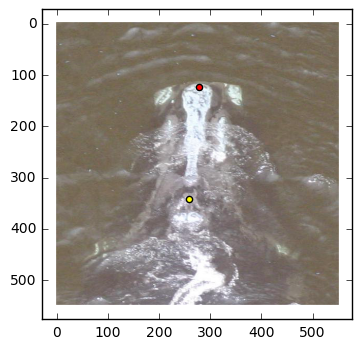

In [42]:
check_pts(tr_files, tr_y, tr_ann)

In [46]:
tr_f = load_array('tr_crop_550_conv_feats.bc')
val_f = load_array('val_crop_550_conv_feats.bc')

In [47]:
tr_f.shape

(3864, 512, 17, 17)

# Fit Model

In [49]:
def getLm():
    return Sequential([
            Flatten(input_shape=(512,17,17)),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(4, activation='linear')
        ])

In [50]:
m = getLm()

In [51]:
m.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [52]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 10s - loss: 62905.7985 - acc: 0.7448 - val_loss: 59264.0066 - val_acc: 0.7221
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 51745.6186 - acc: 0.8336 - val_loss: 42819.0881 - val_acc: 0.7471
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 32381.0318 - acc: 0.8390 - val_loss: 19710.7114 - val_acc: 0.7603


In [53]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 10s - loss: 15837.6658 - acc: 0.8499 - val_loss: 9442.5328 - val_acc: 0.7868
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 6052.7101 - acc: 0.8675 - val_loss: 3764.3659 - val_acc: 0.8176
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 2133.7464 - acc: 0.8996 - val_loss: 3222.5533 - val_acc: 0.8426


In [54]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 1239.1977 - acc: 0.9117 - val_loss: 2708.8286 - val_acc: 0.8647


In [55]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 10s - loss: 1083.4576 - acc: 0.9146 - val_loss: 2814.2781 - val_acc: 0.8456
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 1156.7014 - acc: 0.9213 - val_loss: 2853.0823 - val_acc: 0.8471
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 1184.0697 - acc: 0.9249 - val_loss: 2858.8003 - val_acc: 0.8574


In [57]:
val_preds = m.predict(val_f)

In [58]:
def check_preds(names, pts, df):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    pt = pts[idx,:]    
    
    whale = df[df.Image == f].whaleID.values[0]

    f_name =os.path.join(input_dir, 'valid', whale, f)
    im = cv2.imread(f_name)
    sm = cv2.resize(im, (TARGET_HEIGHT, TARGET_WIDTH))
    fig, ax = plt.subplots()
    ax.imshow(sm)
    ax.scatter(pt[0], pt[1], s=20, c='red', marker='o')
    ax.scatter(pt[2], pt[3], s=20, c='yellow', marker='o')    
    plt.show()


278


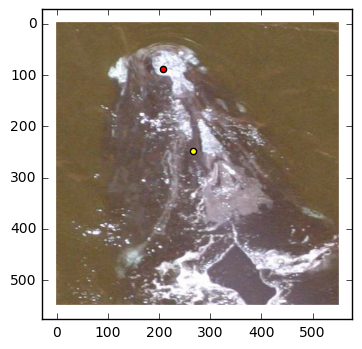

In [95]:
check_preds(val_files, val_preds, val_ann)

# Bigger Model

In [97]:
def getLm():
    return Sequential([
            Flatten(input_shape=(512,17,17)),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(4, activation='linear')
        ])

In [98]:
m = getLm()

In [99]:
m.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [100]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 10s - loss: 63071.9324 - acc: 0.7653 - val_loss: 58209.1470 - val_acc: 0.7750
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 51963.4968 - acc: 0.8284 - val_loss: 44101.4247 - val_acc: 0.7912
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 32310.3115 - acc: 0.8383 - val_loss: 22480.5225 - val_acc: 0.8074


In [101]:
cm.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 10s - loss: 13028.5563 - acc: 0.8610 - val_loss: 7853.2738 - val_acc: 0.8250
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 3758.6615 - acc: 0.8763 - val_loss: 3062.1326 - val_acc: 0.8574
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 1232.5613 - acc: 0.9014 - val_loss: 1900.4248 - val_acc: 0.8897


In [102]:
m.save_weights('pt_reg_550_1900.h5')

In [103]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 718.6361 - acc: 0.9216 - val_loss: 1698.7236 - val_acc: 0.8897


In [104]:
m.save_weights('pt_reg_550_1698.h5')

In [105]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 621.9006 - acc: 0.9205 - val_loss: 1734.3444 - val_acc: 0.8882


In [107]:
m.load_weights('pt_reg_550_1698.h5')

In [109]:
m.optimizer.lr = 0.00001

In [110]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 588.2294 - acc: 0.9213 - val_loss: 1694.8750 - val_acc: 0.8941


In [111]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 559.0145 - acc: 0.9213 - val_loss: 1741.7385 - val_acc: 0.8926


# Even Deeper Model

In [112]:
def getLm():
    return Sequential([
            Flatten(input_shape=(512,17,17)),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(4, activation='linear')
        ])

In [113]:
m = getLm()

In [114]:
m.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [115]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 11s - loss: 63062.5490 - acc: 0.7560 - val_loss: 57923.5727 - val_acc: 0.7515
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 52104.5507 - acc: 0.8144 - val_loss: 42849.5875 - val_acc: 0.8529
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 32543.4796 - acc: 0.8346 - val_loss: 19617.6291 - val_acc: 0.8338


In [116]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 10s - loss: 13219.6802 - acc: 0.8481 - val_loss: 6452.9706 - val_acc: 0.8353
Epoch 2/3
3864/3864 [==============================] - 10s - loss: 3770.2950 - acc: 0.8685 - val_loss: 2124.5707 - val_acc: 0.8632
Epoch 3/3
3864/3864 [==============================] - 10s - loss: 1277.6139 - acc: 0.8991 - val_loss: 1448.9679 - val_acc: 0.8868


In [117]:
m.save_weights('pt_reg_1448.h5')

In [118]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 779.7407 - acc: 0.9198 - val_loss: 1352.7524 - val_acc: 0.9059


In [119]:
m.save_weights('pt_reg_1352.h5')

In [120]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 632.6997 - acc: 0.9229 - val_loss: 1336.7772 - val_acc: 0.9074


In [121]:
m.save_weights('pt_reg_1336.h5')

In [122]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 10s - loss: 574.0649 - acc: 0.9281 - val_loss: 1368.6689 - val_acc: 0.9029


# Even Bigger

In [123]:
def getLm():
    return Sequential([
            Flatten(input_shape=(512,17,17)),
            BatchNormalization(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(4, activation='linear')
        ])

In [124]:
m = getLm()

In [125]:
m.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [126]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 18s - loss: 62963.8706 - acc: 0.7513 - val_loss: 59257.1385 - val_acc: 0.7853
Epoch 2/3
3864/3864 [==============================] - 17s - loss: 52179.8569 - acc: 0.8108 - val_loss: 43261.2290 - val_acc: 0.8456
Epoch 3/3
3864/3864 [==============================] - 17s - loss: 32678.5496 - acc: 0.8282 - val_loss: 21048.7353 - val_acc: 0.7868


In [127]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=3)

Train on 3864 samples, validate on 680 samples
Epoch 1/3
3864/3864 [==============================] - 17s - loss: 13290.4787 - acc: 0.8478 - val_loss: 6917.9154 - val_acc: 0.8632
Epoch 2/3
3864/3864 [==============================] - 17s - loss: 3834.5549 - acc: 0.8724 - val_loss: 2421.3315 - val_acc: 0.8706
Epoch 3/3
3864/3864 [==============================] - 17s - loss: 1347.0691 - acc: 0.8962 - val_loss: 1533.5777 - val_acc: 0.9000


In [128]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=1)

Train on 3864 samples, validate on 680 samples
Epoch 1/1
3864/3864 [==============================] - 18s - loss: 805.6027 - acc: 0.9045 - val_loss: 1458.6259 - val_acc: 0.8941


In [129]:
m.fit(tr_f, tr_y, validation_data=(val_f, val_y), nb_epoch=2)

Train on 3864 samples, validate on 680 samples
Epoch 1/2
3864/3864 [==============================] - 17s - loss: 685.2755 - acc: 0.9149 - val_loss: 1406.8904 - val_acc: 0.9059
Epoch 2/2
3864/3864 [==============================] - 17s - loss: 631.9033 - acc: 0.9205 - val_loss: 1619.9538 - val_acc: 0.8941


# Best Model

In [130]:
def getLm():
    return Sequential([
            Flatten(input_shape=(512,17,17)),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(4, activation='linear')
        ])

In [131]:
m = getLm()

In [132]:
m.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [133]:
m.load_weights('pt_reg_1336.h5')

In [134]:
val_preds = m.predict(val_f)

283


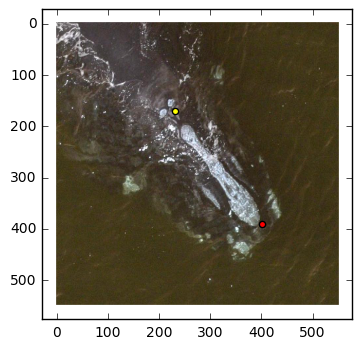

In [150]:
check_preds(val_files, val_preds, val_ann)

In [151]:
test_f = load_array('test_crop_550_conv_feats.bc')

In [152]:
test_b = ImageDataGenerator().flow_from_directory(input_dir+'/test', batch_size=1, shuffle=True)

Found 6925 images belonging to 1 classes.


In [153]:
test_files = test_b.filenames

In [158]:
test_files = [f.split('/')[-1] for f in test_files]

In [155]:
test_preds = m.predict(test_f)

In [160]:
def check_test(names, pts):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    pt = pts[idx,:]    
    f_name =os.path.join(input_dir, 'test', 'unknown', f)
    im = cv2.imread(f_name)
    sm = cv2.resize(im, (TARGET_HEIGHT, TARGET_WIDTH))
    fig, ax = plt.subplots()
    ax.imshow(sm)
    ax.scatter(pt[0], pt[1], s=20, c='red', marker='o')
    ax.scatter(pt[2], pt[3], s=20, c='yellow', marker='o')    
    plt.show()


5188


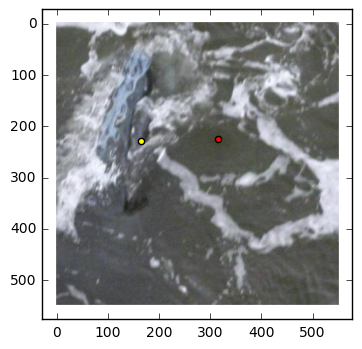

In [209]:
check_test(test_files, test_preds)

In [210]:
test_data = np.hstack((np.array(test_files)[:, np.newaxis], test_preds))

In [212]:
test_preds

array([[ 254.5152,  339.4501,  270.1441,   80.5656],
       [ 312.916 ,  192.752 ,  247.3542,  256.9499],
       [  75.2653,  206.6452,  382.4116,  162.7016],
       ..., 
       [ 398.9888,   54.4144,  217.3932,  237.3008],
       [ 417.1386,  330.0214,  168.8052,  135.6019],
       [ 323.0161,  145.8067,  233.6838,  118.4305]], dtype=float32)

In [213]:
test_df = pd.DataFrame(test_data, columns=['Image', 'x1', 'y1', 'x2', 'y2'])

In [214]:
len(test_df)

6925

In [215]:
test_df.head()

,Image,x1,y1,x2,y2
0,w_8037.jpg,254.515167236,339.450134277,270.144104004,80.5655975342
1,w_4494.jpg,312.916015625,192.751953125,247.354248047,256.949920654
2,w_4673.jpg,75.2652511597,206.645233154,382.411560059,162.701583862
3,w_8273.jpg,152.168197632,326.845825195,284.177642822,174.622955322
4,w_7611.jpg,357.06072998,137.456939697,145.906723022,328.053009033


In [216]:
%pwd

u'/home/ubuntu/courses/deeplearning1/nbs/whale_recognition'

In [217]:
test_df.to_csv('test_pts_550.csv', index='False')